# Features 

## Importation des librairies

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
#Fonctions statistiques 
import scipy.stats

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp
# FFT
from scipy.fftpack import fft
# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("whitegrid")

# Interactive display
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
from IPython.display import display

## Importation des données

On lit les données d'apprentissage et de test et on forme une liste de toutes les données contenant au total 428 vols.

In [6]:
with open('X_1024', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_comp, ind = mon_depickler.load() #X_1024 : données  #ind : liste des indices des signaux
n = len(liste_comp) #nb de signaux
liste_appr = list(np.asarray(X_1024)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(X_1024)[np.asarray(ind) > 299])

## Liste des features que l'on veut  

- min, max
- mean 
- écart type 
- Skewness 
- Kurtosis 
- Energy 
- Average Crossing 

A ajouter ?

- Distribution spectrale d'énergie 
- Pourcentage d'extrema locaux 

https://arc.aiaa.org/doi/pdf/10.2514/6.2016-2430

In [12]:
listeMin = [min(liste) for liste in liste_comp]
listeMax = [max(liste) for liste in liste_comp]
listeMean = [np.mean(liste) for liste in liste_comp]
listeStd = [np.std(liste) for liste in liste_comp]
listeSkewness = [scipy.stats.skew(liste) for liste in liste_comp]
listeKurtosis = [scipy.stats.kurtosis(liste) for liste in liste_comp]
listeEnergy = [sum(np.asarray(liste)**2)/len(liste) for liste in liste_comp]
listeAverageCross = [sum(1*(liste > np.mean(liste)))/len(liste) for liste in liste_comp]

## Construction Data frame

In [13]:
dico = {"Min": listeMin, "Max": listeMax, "Moyenne": listeMean, "Ecart-type": listeStd, "Skewness" : listeSkewness, "Kurtosis": listeKurtosis, "Energie": listeEnergy, "Average_Crossing": listeAverageCross}
DataFeatures = pd.DataFrame(dico)

In [14]:
DataFeatures.head()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
0,1280.0,3552.0,1722.421875,358.733549,2.917743,10.419594,3.095427e+06,0.161133
1,1296.0,3320.0,1700.945312,295.020307,1.810466,5.878068,2.980252e+06,0.359375
2,1280.0,3392.0,1649.500000,232.593798,4.363017,28.234724,2.774950e+06,0.804688
3,1288.0,3208.0,1588.484375,215.938105,3.289758,21.013905,2.569912e+06,0.649414
4,1296.0,2328.0,1612.734375,182.655648,0.831740,2.557918,2.634275e+06,0.695312


In [15]:
DataFeatures.describe()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,4.250000e+02,425.000000
mean,1306.470588,3033.543529,1661.196342,255.460036,1.951539,10.360256,2.846791e+06,0.509256
std,88.135641,812.764412,80.542560,124.590097,1.877247,10.616838,3.286491e+05,0.234078
min,72.000000,1624.000000,1433.578125,49.612974,-3.176870,-1.892489,2.090802e+06,0.049805
25%,1288.000000,2456.000000,1608.375000,156.264005,0.940329,2.907355,2.632092e+06,0.266602
50%,1304.000000,2952.000000,1645.171875,227.040181,2.136654,7.485112,2.772037e+06,0.607422
75%,1320.000000,3488.000000,1710.398438,315.529632,3.265087,13.939837,3.030541e+06,0.701172
max,1464.000000,5688.000000,1925.945312,890.446850,7.167347,61.276323,4.316083e+06,0.915039


In [42]:
data_train = DataFeatures.iloc[: len(liste_appr), :]
data_test = DataFeatures.iloc[len(liste_appr) :, :]
data_test.describe()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.280000e+02,128.000000
mean,1313.578125,3014.812500,1680.330322,252.740152,1.711669,10.287513,2.911788e+06,0.520439
std,120.235635,831.063125,87.685105,130.014816,2.125168,11.898189,3.505979e+05,0.229796
min,72.000000,1624.000000,1519.992188,49.612974,-3.176870,-1.892489,2.384475e+06,0.069336
25%,1304.000000,2428.000000,1619.229492,152.331889,0.209614,2.594451,2.661949e+06,0.268799
50%,1320.000000,2932.000000,1659.732422,209.367003,1.809109,6.970344,2.821575e+06,0.607910
75%,1360.000000,3560.000000,1745.200195,311.087447,2.999567,13.660760,3.122891e+06,0.709473
max,1432.000000,5616.000000,1882.468750,655.191652,6.932129,56.531742,3.851198e+06,0.915039


## ACP 

In [16]:
pca = sd.PCA()
data = DataFeatures[["Min","Max","Moyenne","Ecart-type","Skewness","Kurtosis","Energie", "Average_Crossing"]]
C = pca.fit_transform(sp.scale(data))

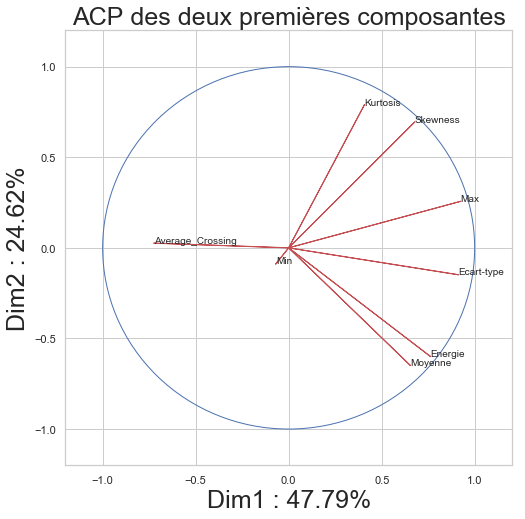

In [17]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
ax.set_xlabel("Dim1 : " + str(round(pca.explained_variance_ratio_[:10][0]*100,2))+ "%" ,size=25)
ax.set_ylabel("Dim2 : " + str(round(pca.explained_variance_ratio_[:10][1]*100,2)) + "%",size=25)
ax.set_title("ACP des deux premières composantes",size=25)
plt.show()

In [21]:
def plot_var_ACP(X_acp) :
    acp = sd.PCA()
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(5), acp.explained_variance_ratio_[:5]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:10])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True) :
    acp = sd.PCA()
    fig = plt.figure(figsize=(13,8))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], range(len(liste_comp))) :
        ax.plot(x,y,marker=".", color=dict_color[s < len(liste_appr)])
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()

In [22]:
len(liste_appr)

297

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

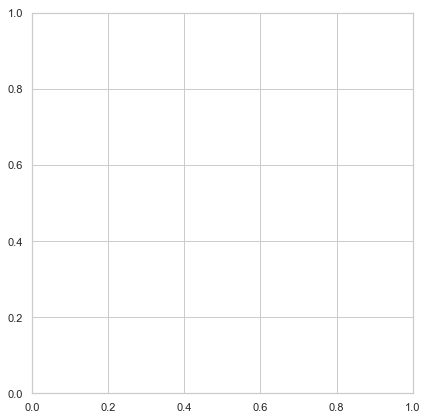

In [67]:
plot_var_ACP(C)

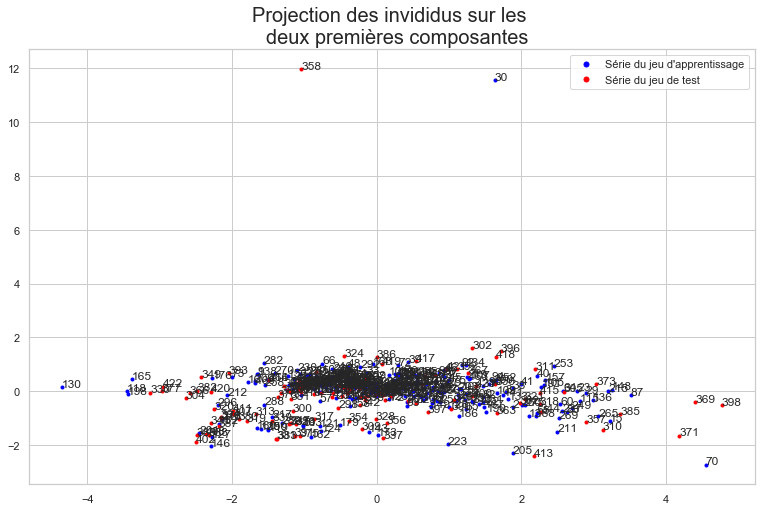

In [66]:
plot_proj_ACP(C, 1, 2)

## CAH 

In [25]:
def plot_dendro(Z) :
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram(Z, p=10, leaf_rotation=45., leaf_font_size=15, truncate_mode="level")  # font size for the x axis labels

    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    plt.show()
    


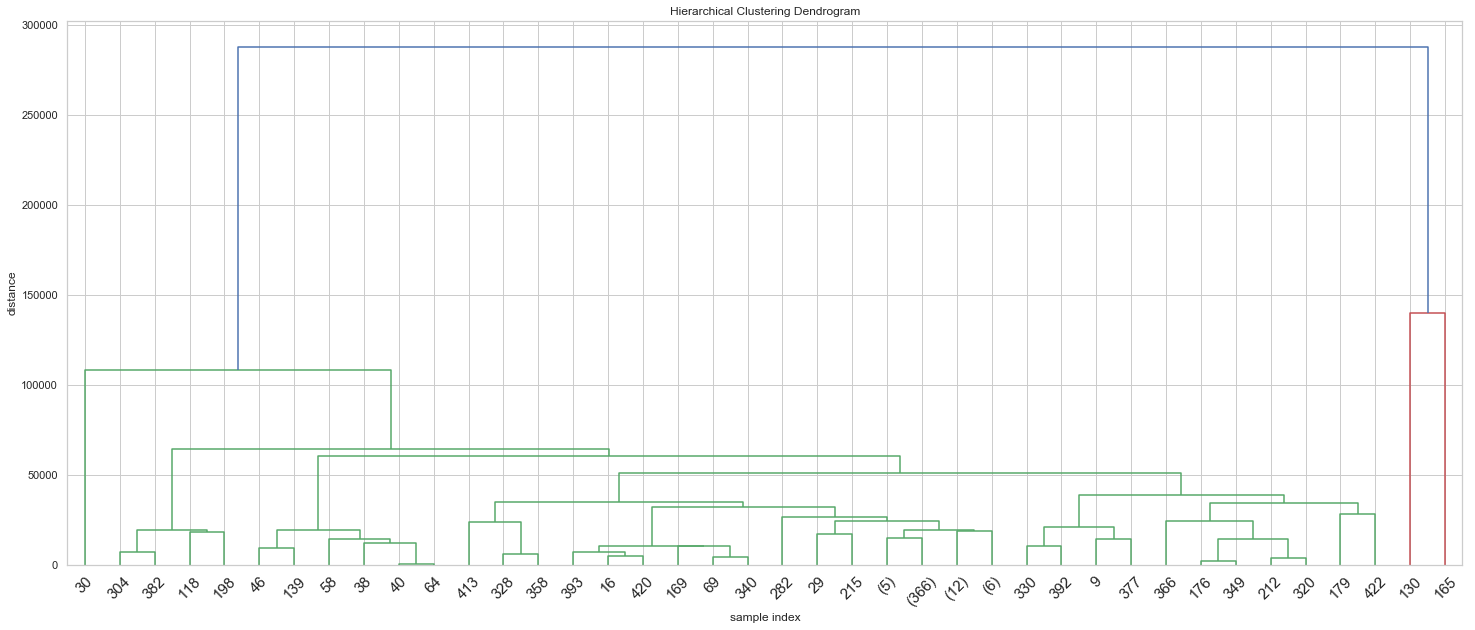

In [26]:
Z = sch.linkage(DataFeatures, 'single')
plot_dendro(Z)

## Isolation Forest 

In [27]:
def plot_result_IF(fig, ax, CT, title='', axis_x='', axis_y='', fontsize=25) :
    y_lim = (-1.13, 1.13)
    x_lim = [-5, len(liste_comp) + 5]
    CT_Normal = CT[CT.pred == 1]
    CT_Anomaly = CT[CT.pred == -1]
    
    ax.scatter(CT_Normal.index, - CT_Normal.pred, color="green")
    #ax.scatter(CT_Anomaly.index, - CT_Anomaly.pred, color="red", label="Anomaly")
    
    for x,y,s in zip(CT_Anomaly.index, - CT_Anomaly.pred, map(str,CT_Anomaly.index)):
        ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")

    ax.plot(x_lim, [0,0], color="black")
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

In [31]:
clf = se.IsolationForest(n_estimators=100, contamination=20/428, bootstrap=True, n_jobs=-1, behaviour="new")
clf.fit(DataFeatures)
y_pred = clf.predict(DataFeatures)

CT_IF = pd.DataFrame(list(y_pred), columns=["pred"]) 

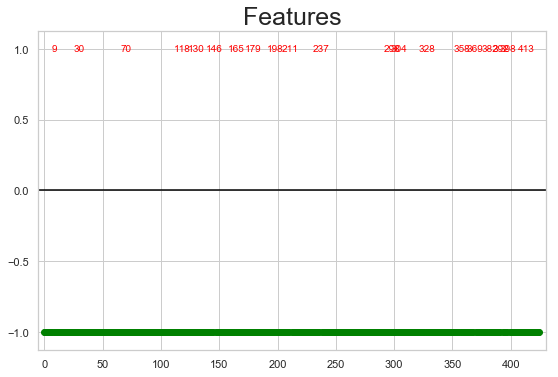

In [32]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(3,2,1)
plot_result_IF(fig, ax, CT_IF, title="Features", fontsize=25)

In [33]:
print("Anomalies : ", CT_IF[CT_IF.pred == -1].index.values)

Anomalies :  [  9  30  70 118 130 146 165 179 198 211 237 298 304 328 358 369 382 392
 398 413]


## OC-SVM 

(21,)
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1  1 -1
 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1
  1 -1  1 -1 -1 -1  1 -1]


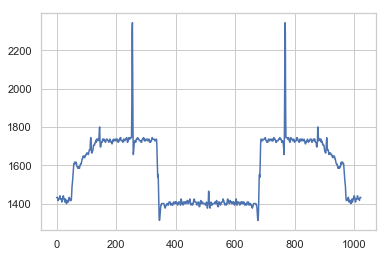

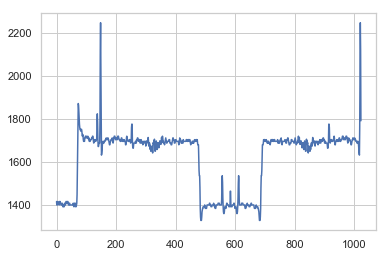

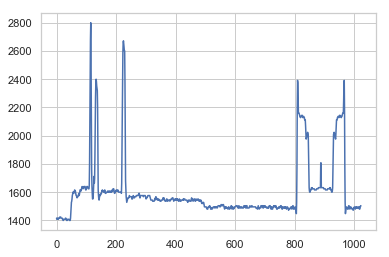

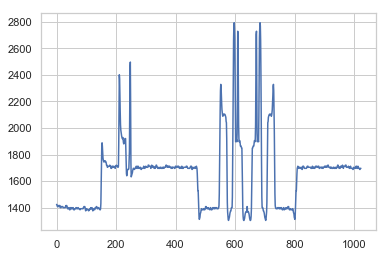

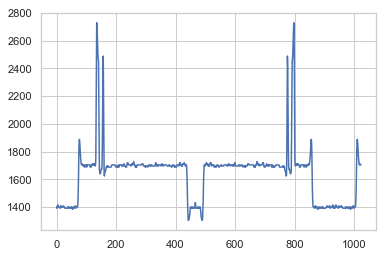

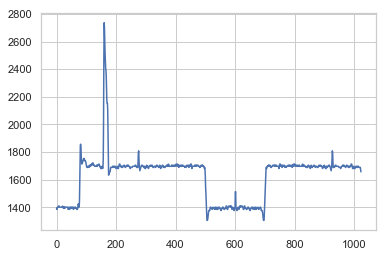

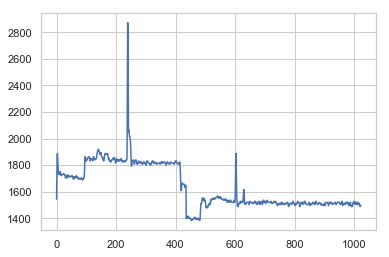

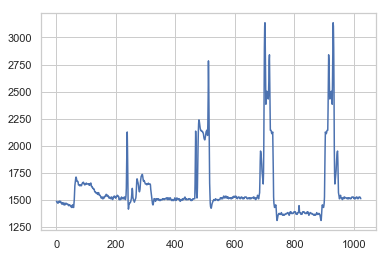

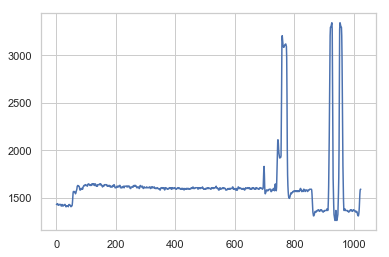

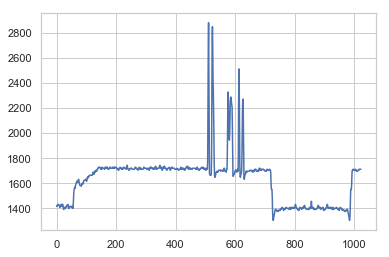

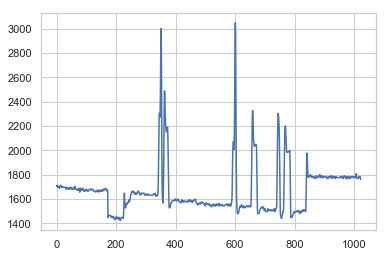

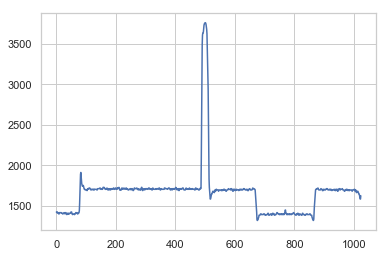

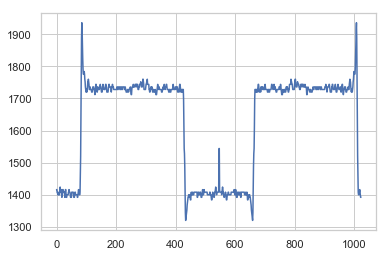

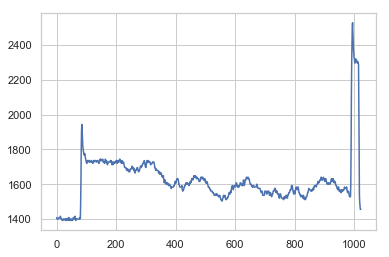

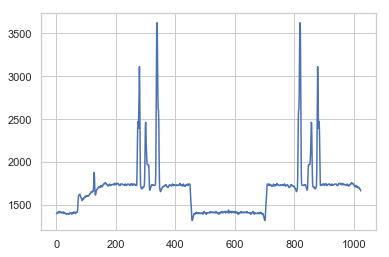

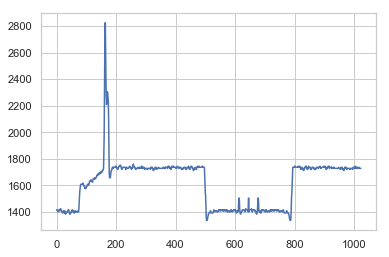

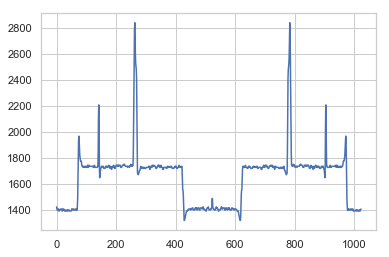

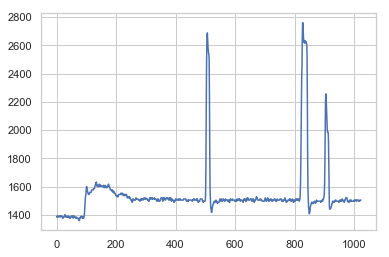

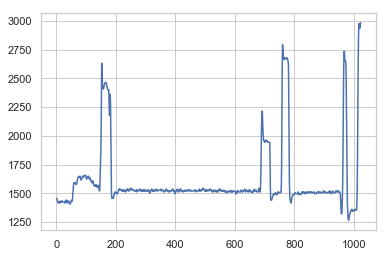

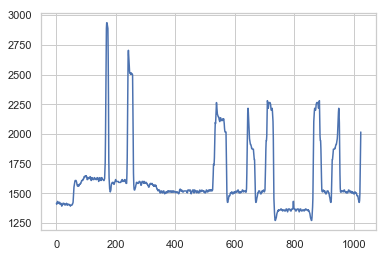

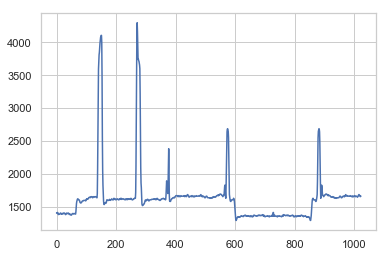

In [80]:
from sklearn.svm import OneClassSVM
outlier_prop = 20 / 425  # Ou 20 / (n-20) ?  Ou 20 / 300 ?
OCSVM = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.00000005)
y_pred = OCSVM.fit(data_train).predict(data_test)
print(np.asarray(y_pred)[np.asarray(y_pred) == 1].shape)
print(y_pred)
for i, serie in enumerate(liste_test):
    if y_pred[i] == 1:
        plt.plot(serie)
        plt.show()

Dans tous les signaux qui ressortent comme anormaux on voit notre symétrie barbare. Est-ce que c'était une bonne idée au final ? Go tester sur les signaux de base.

In [82]:
with open('liste_propre', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_comp, ind = mon_depickler.load() #liste_comp : données  #ind : liste des indices des signaux
n = len(liste_comp) #nb de signaux
liste_appr = list(np.asarray(liste_comp)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(liste_comp)[np.asarray(ind) > 299])

In [83]:
listeMin = [min(liste) for liste in liste_comp]
listeMax = [max(liste) for liste in liste_comp]
listeMean = [np.mean(liste) for liste in liste_comp]
listeStd = [np.std(liste) for liste in liste_comp]
listeSkewness = [scipy.stats.skew(liste) for liste in liste_comp]
listeKurtosis = [scipy.stats.kurtosis(liste) for liste in liste_comp]
listeEnergy = [sum(np.asarray(liste)**2)/len(liste) for liste in liste_comp]
listeAverageCross = [sum(1*(liste > np.mean(liste)))/len(liste) for liste in liste_comp]

## Construction Data frame

In [84]:
dico = {"Min": listeMin, "Max": listeMax, "Moyenne": listeMean, "Ecart-type": listeStd, "Skewness" : listeSkewness, "Kurtosis": listeKurtosis, "Energie": listeEnergy, "Average_Crossing": listeAverageCross}
DataFeatures = pd.DataFrame(dico)

In [85]:
DataFeatures.head()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
0,1280.0,3552.0,1734.202643,345.126677,2.711380,9.500535,3.126571e+06,0.182085
1,1296.0,3320.0,1693.226667,295.348143,1.808988,5.835758,2.954247e+06,0.413333
2,1280.0,3392.0,1654.509434,187.856340,4.883878,40.924481,2.772691e+06,0.849057
3,1288.0,3208.0,1616.614610,225.503825,3.493780,21.057169,2.664295e+06,0.716625
4,1296.0,2328.0,1607.755258,183.891068,0.834251,2.440176,2.618693e+06,0.684512


In [86]:
DataFeatures.describe()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,4.250000e+02,425.000000
mean,1304.512941,3052.385882,1662.325406,257.244272,2.005907,10.484788,2.851309e+06,0.503975
std,87.455490,822.272898,78.989406,124.984507,1.844992,10.724655,3.271909e+05,0.230426
min,72.000000,1624.000000,1457.300813,53.978124,-2.870609,-1.826071,2.149992e+06,0.056159
25%,1288.000000,2456.000000,1608.691176,158.366617,1.005085,2.938023,2.627719e+06,0.261808
50%,1304.000000,2968.000000,1647.570662,225.503825,2.208380,7.680911,2.771719e+06,0.593176
75%,1320.000000,3504.000000,1713.142857,311.067269,3.223703,14.507249,3.028428e+06,0.692868
max,1464.000000,5984.000000,1910.453608,860.538894,6.964047,58.596857,4.117989e+06,0.861538


In [87]:
data_train = DataFeatures.iloc[: len(liste_appr), :]
data_test = DataFeatures.iloc[len(liste_appr) :, :]
data_test.describe()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.280000e+02,128.000000
mean,1312.140625,3041.000000,1681.131871,256.957453,1.832478,10.296867,2.916155e+06,0.501287
std,119.882931,836.939306,87.738878,128.116474,2.059130,12.165659,3.564267e+05,0.235063
min,72.000000,1624.000000,1524.917609,57.801247,-2.870609,-1.763901,2.362471e+06,0.070284
25%,1302.000000,2458.000000,1613.451399,159.614775,0.145547,2.287839,2.650776e+06,0.235914
50%,1320.000000,2940.000000,1658.573002,216.153077,1.883105,6.979544,2.811549e+06,0.600456
75%,1354.000000,3570.000000,1752.847804,303.359617,3.154531,13.219379,3.138162e+06,0.699531
max,1432.000000,5616.000000,1894.520301,703.874510,6.964047,58.596857,4.084646e+06,0.861538


(23,)


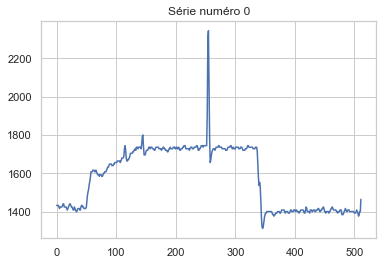

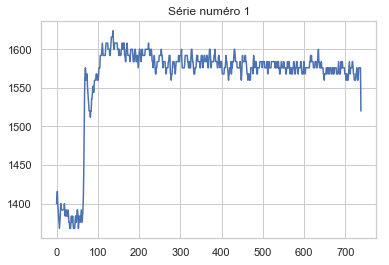

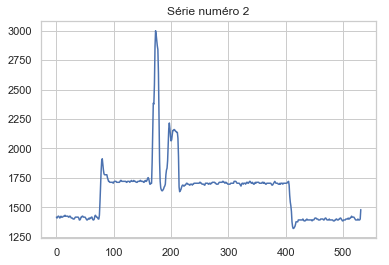

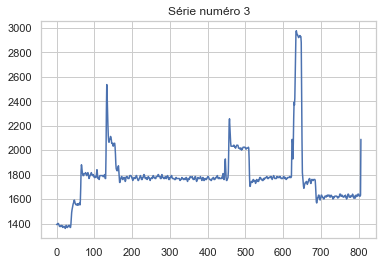

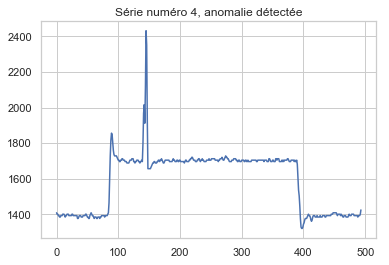

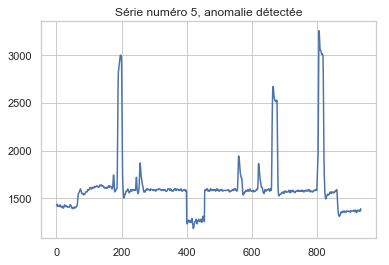

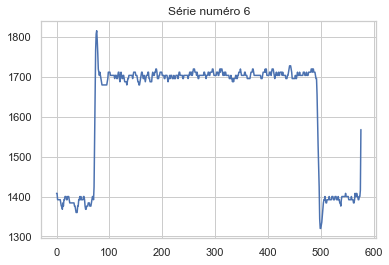

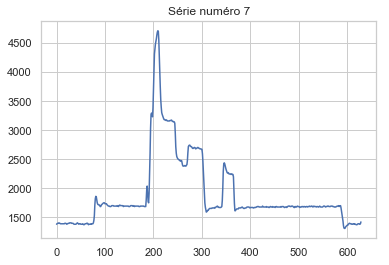

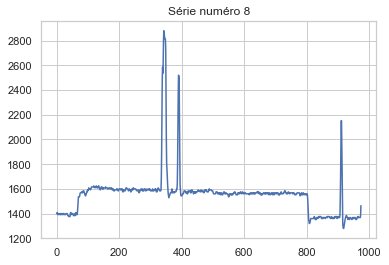

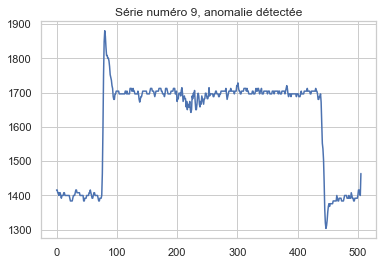

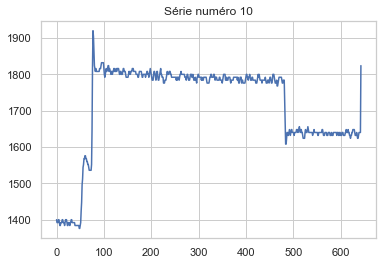

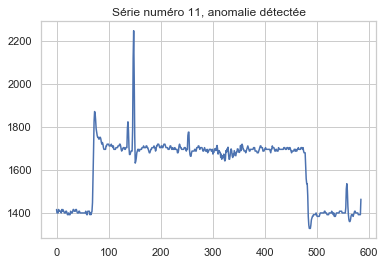

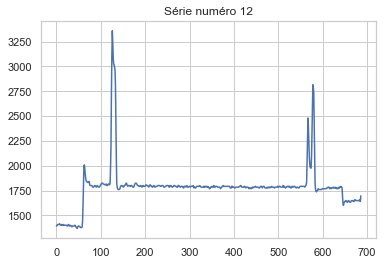

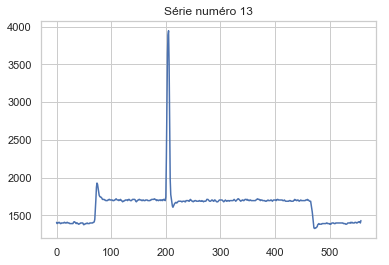

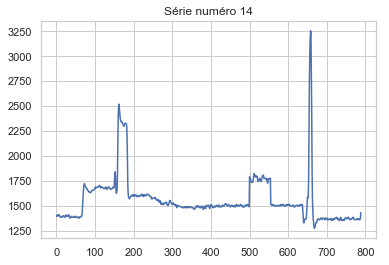

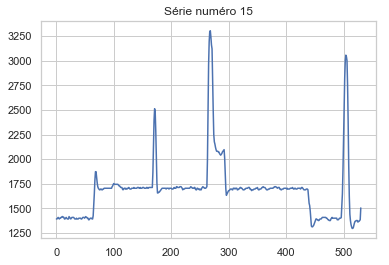

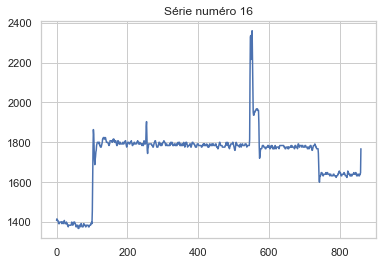

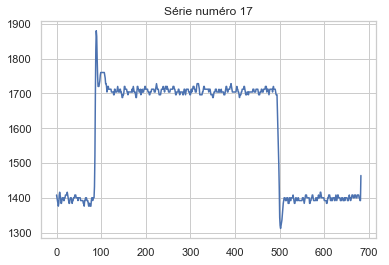

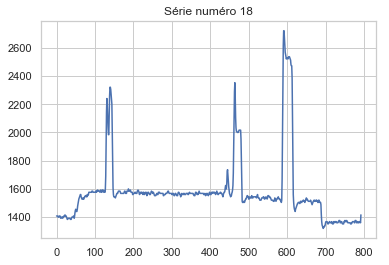

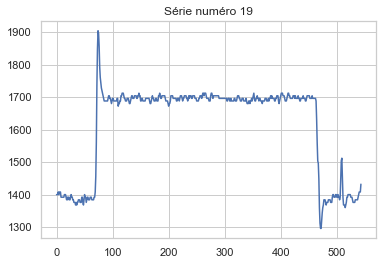

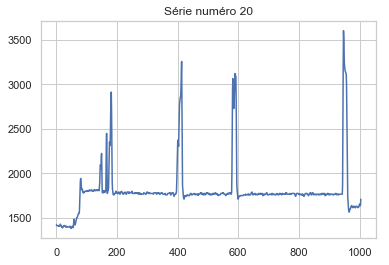

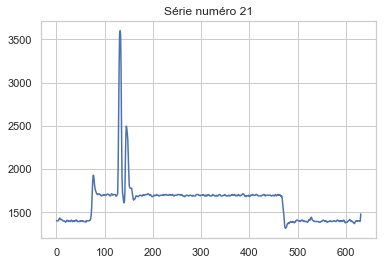

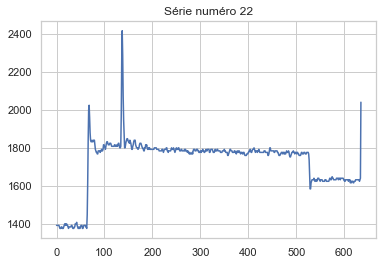

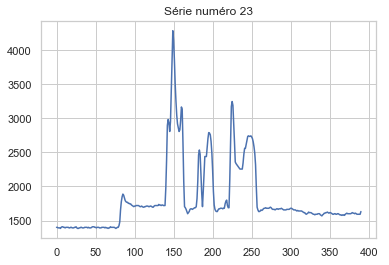

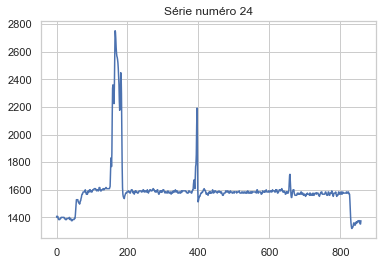

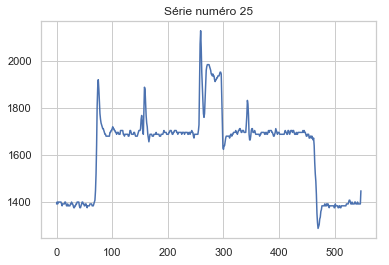

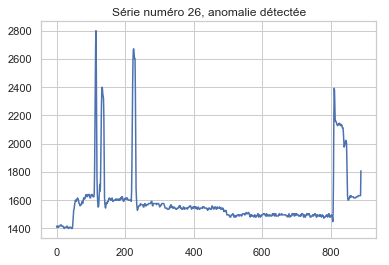

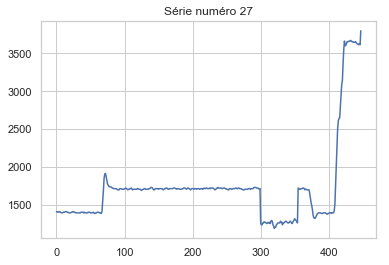

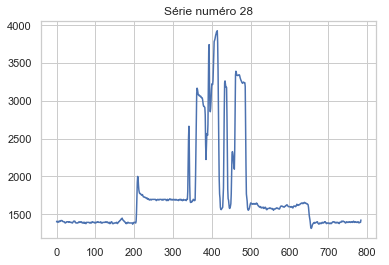

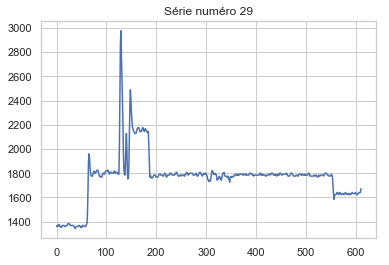

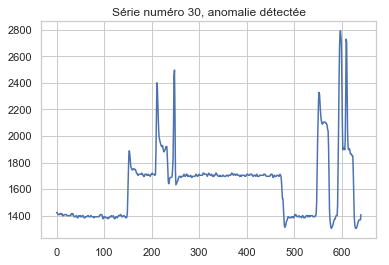

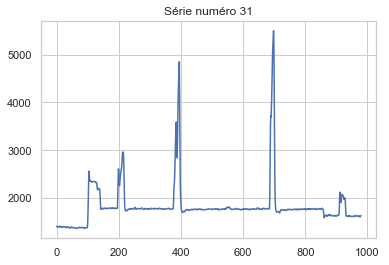

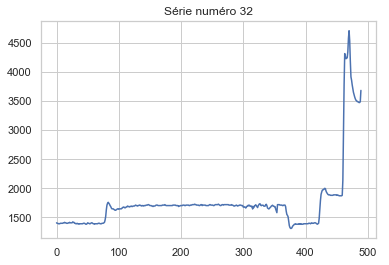

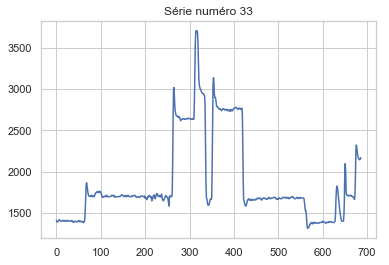

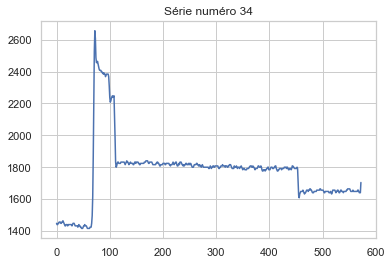

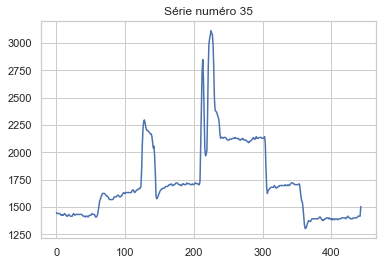

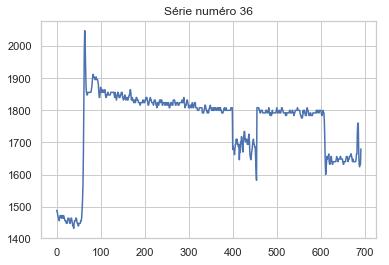

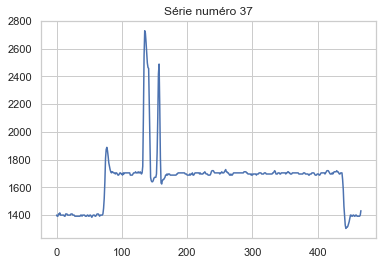

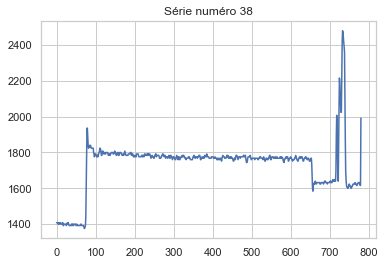

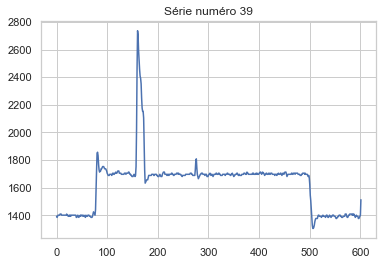

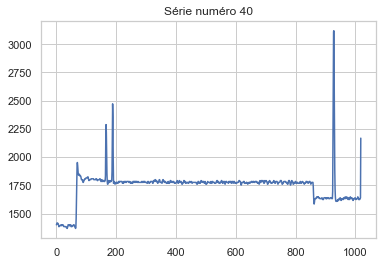

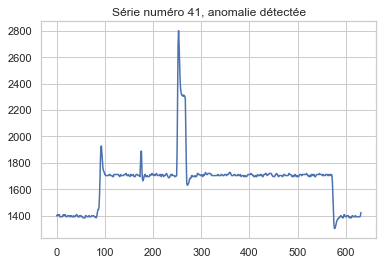

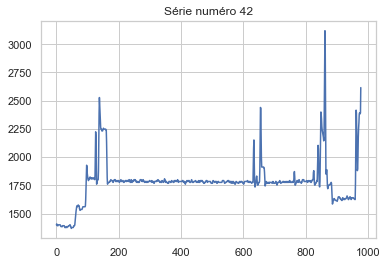

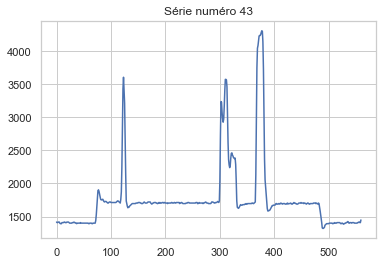

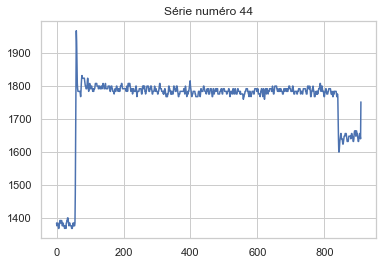

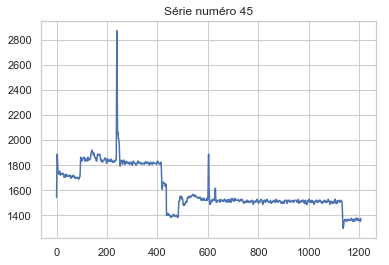

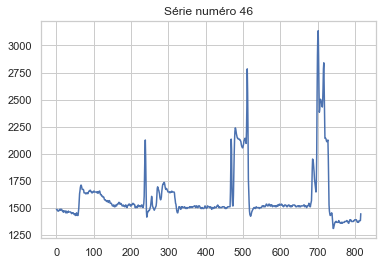

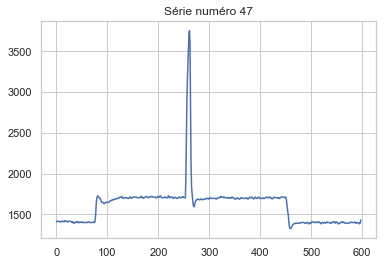

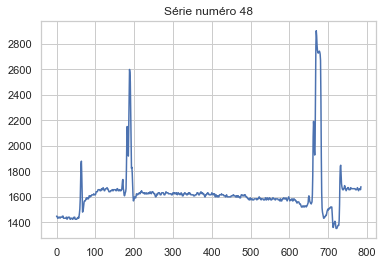

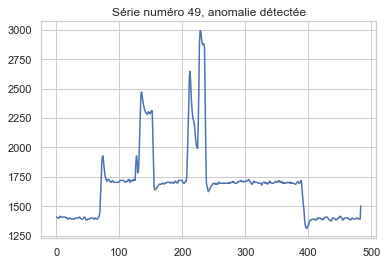

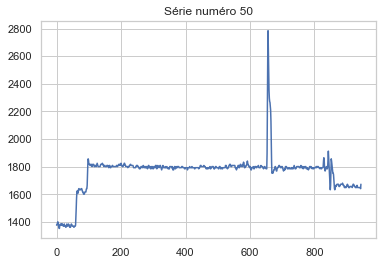

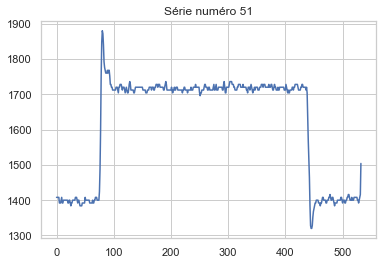

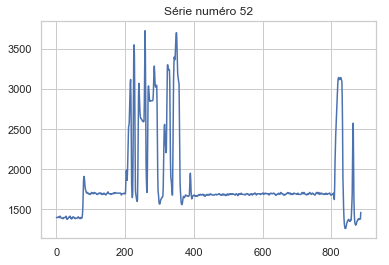

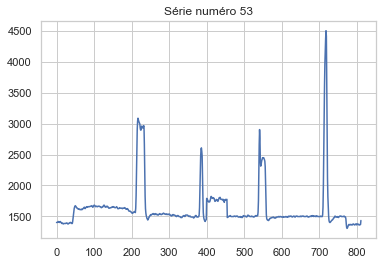

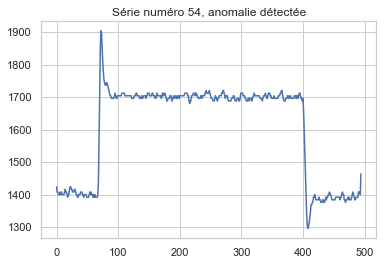

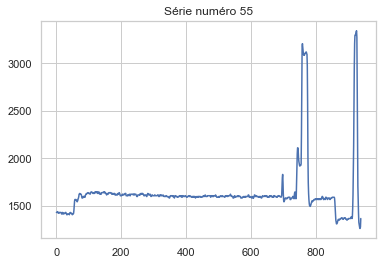

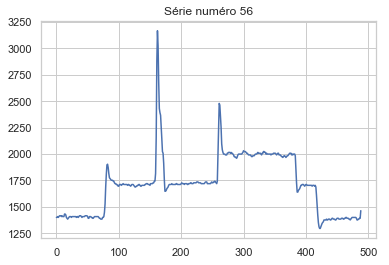

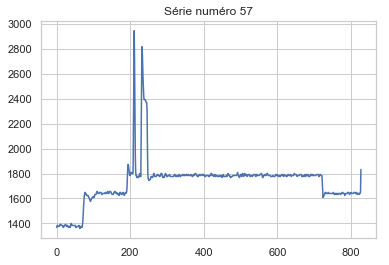

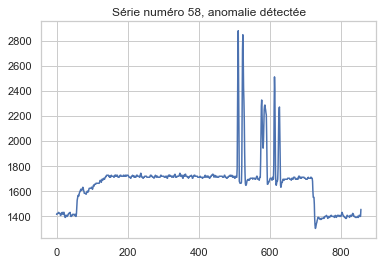

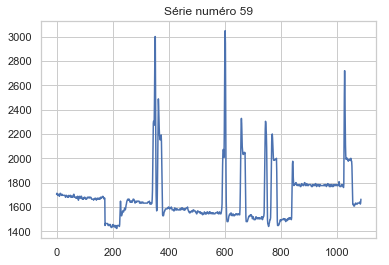

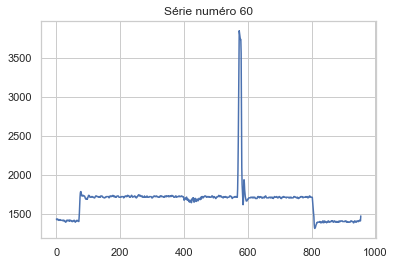

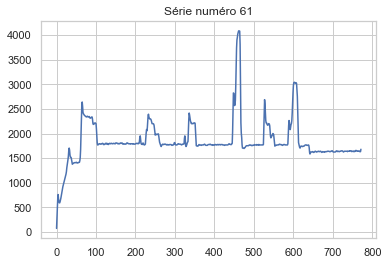

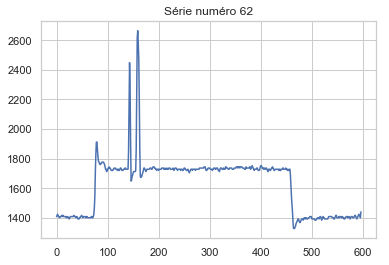

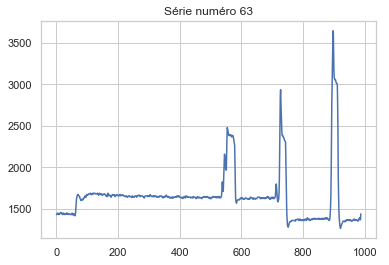

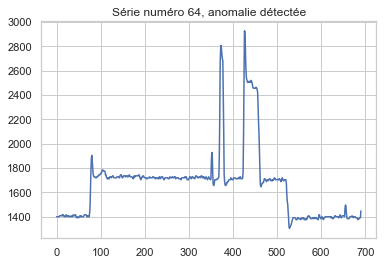

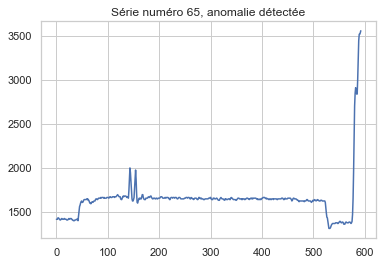

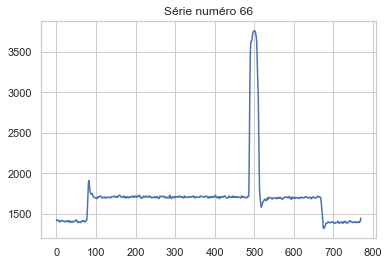

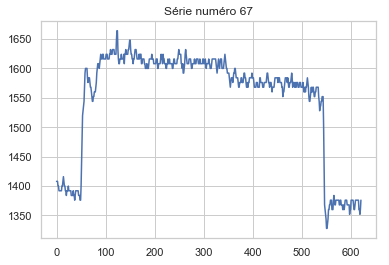

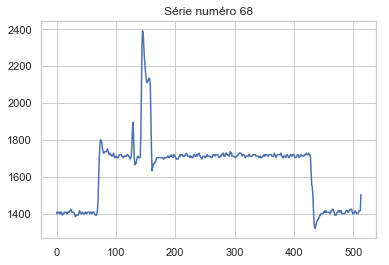

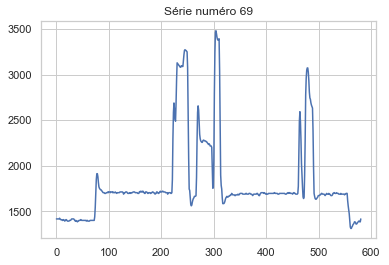

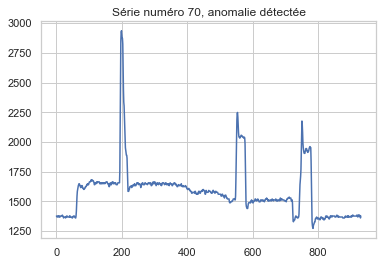

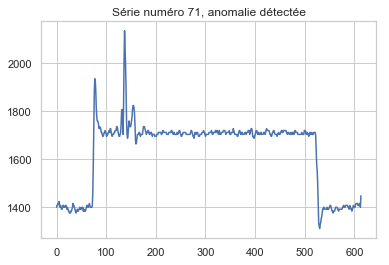

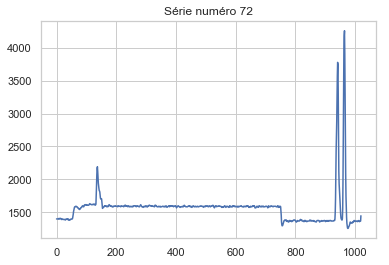

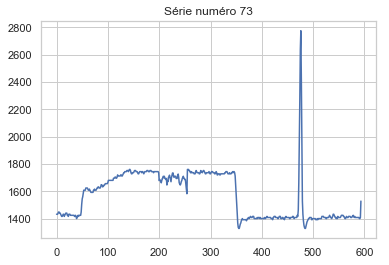

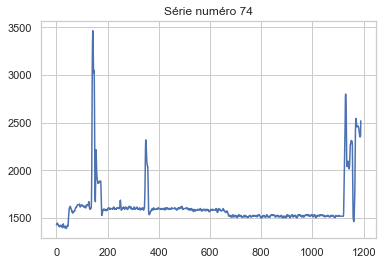

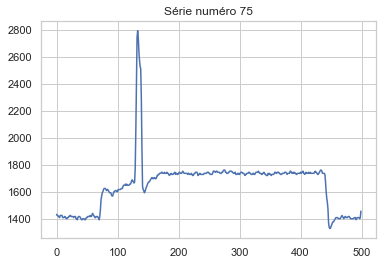

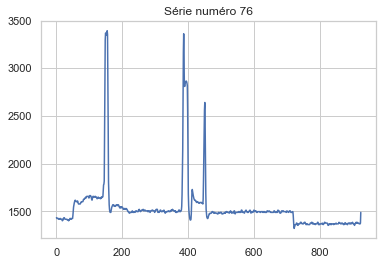

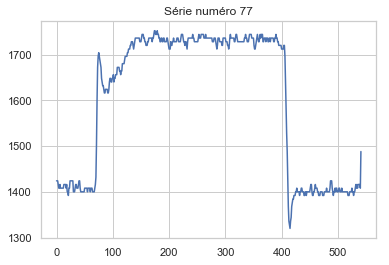

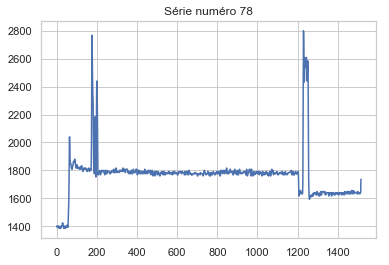

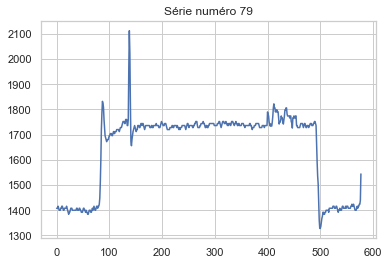

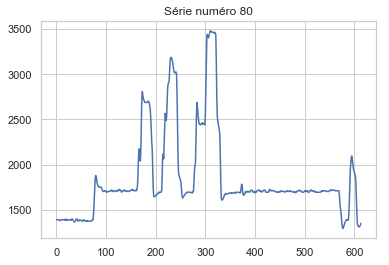

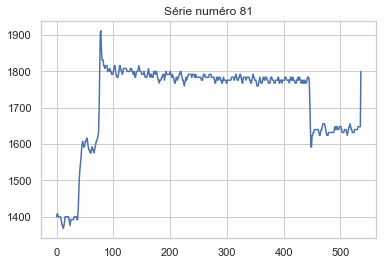

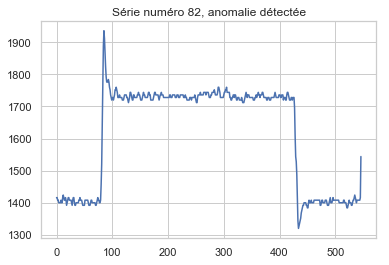

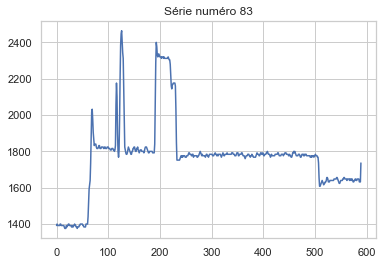

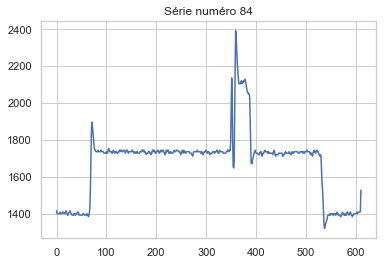

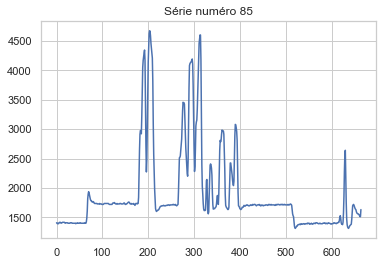

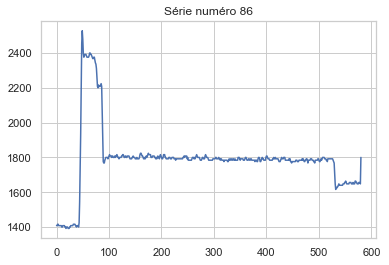

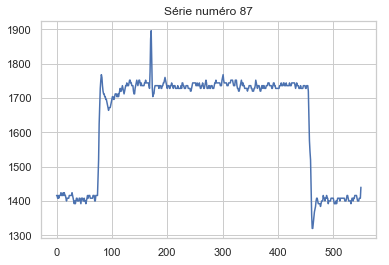

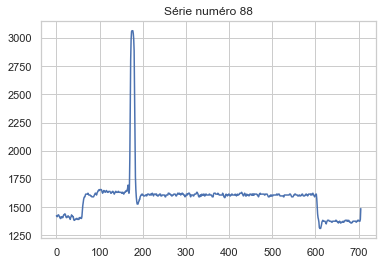

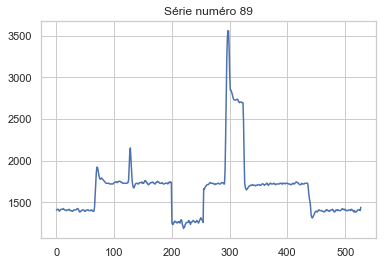

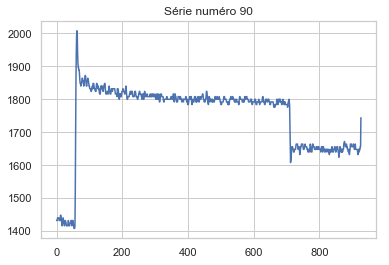

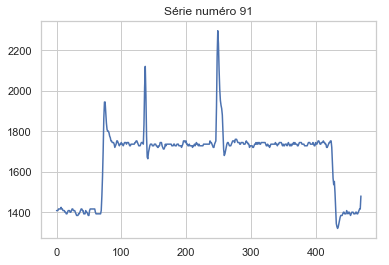

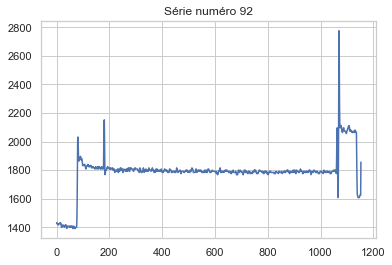

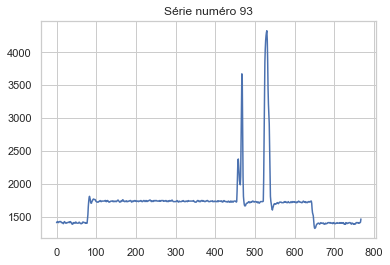

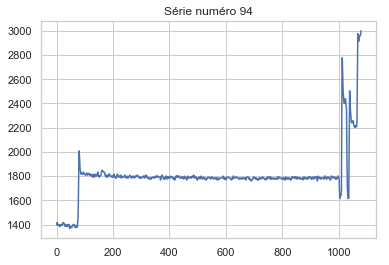

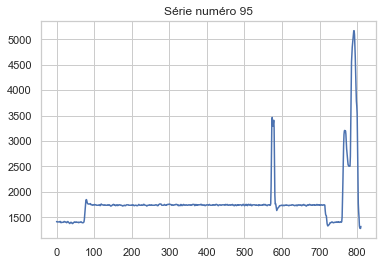

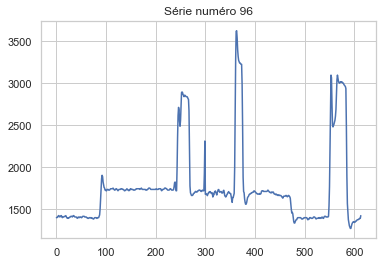

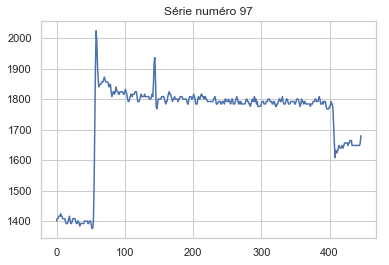

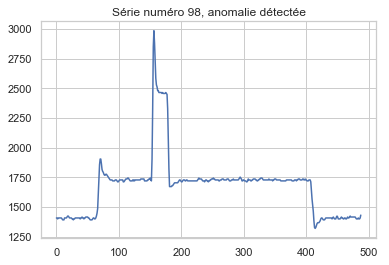

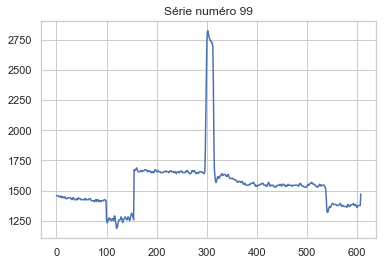

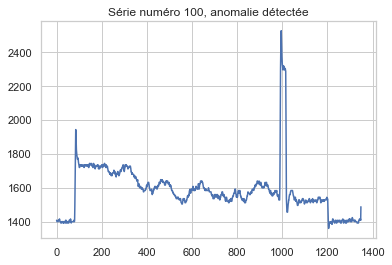

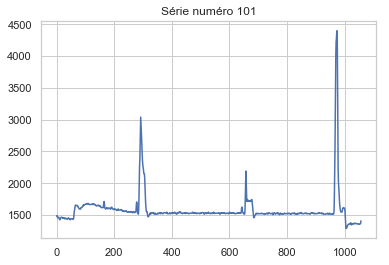

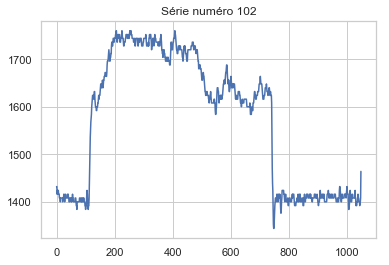

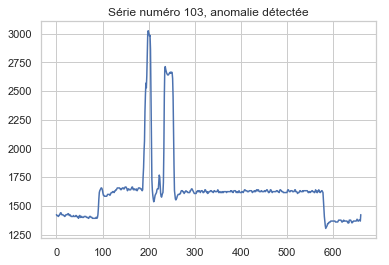

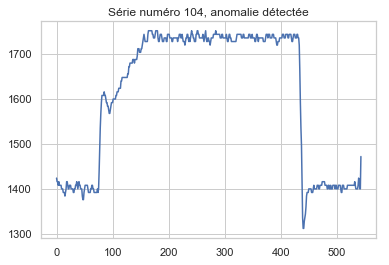

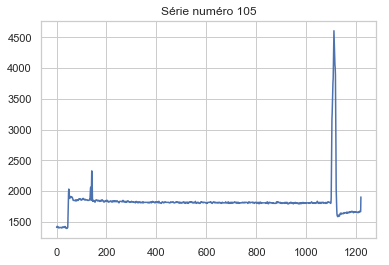

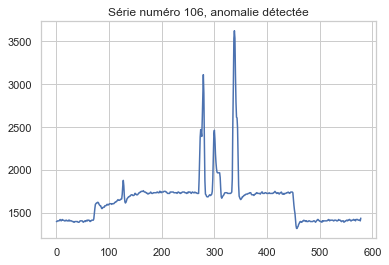

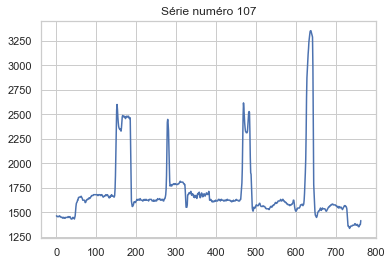

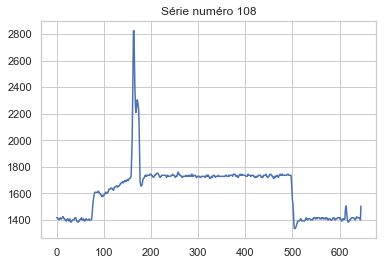

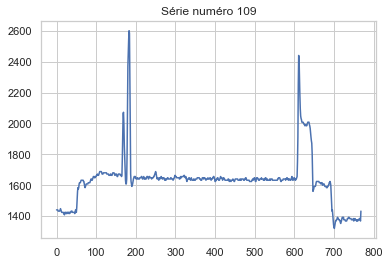

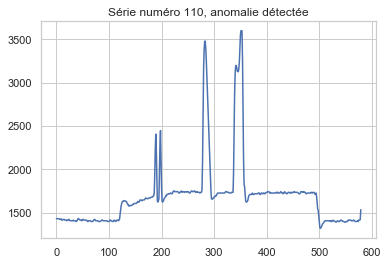

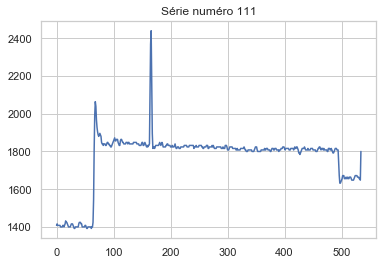

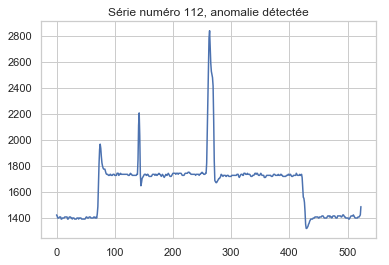

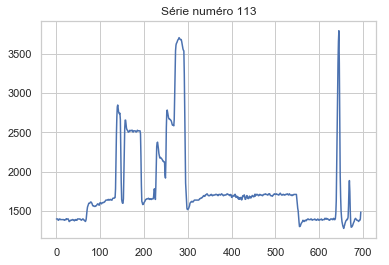

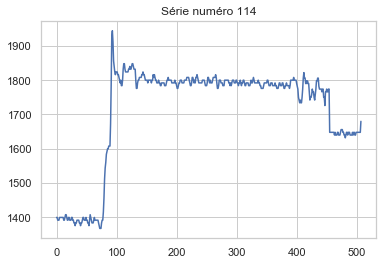

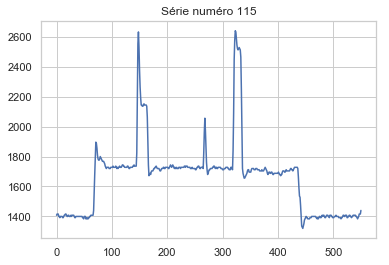

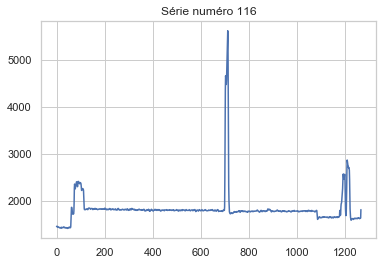

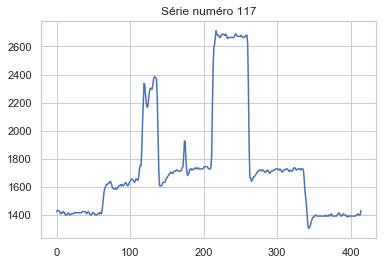

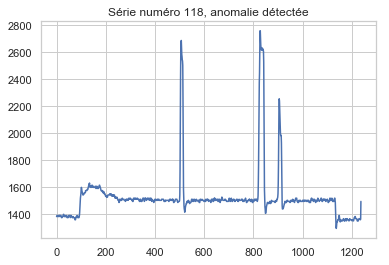

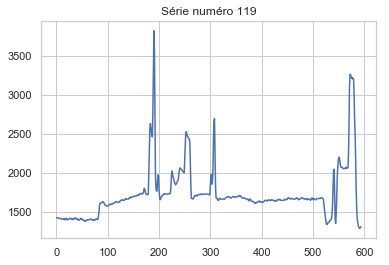

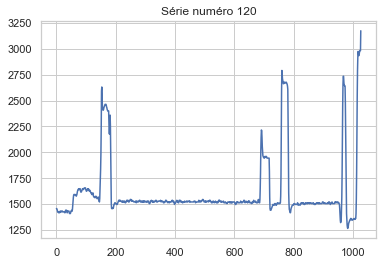

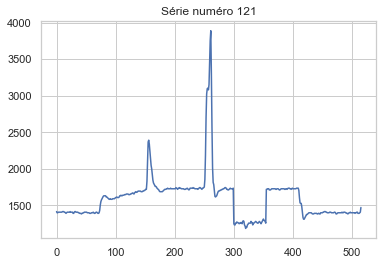

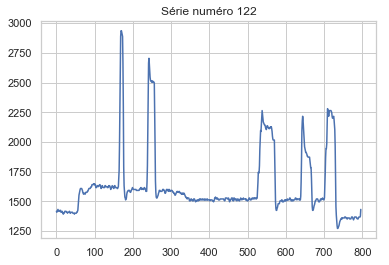

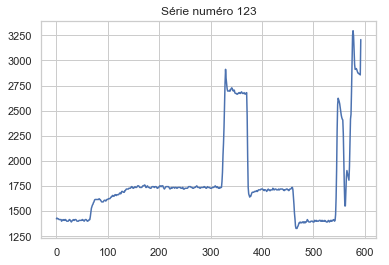

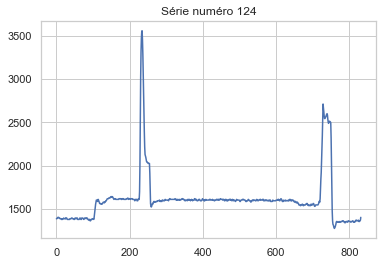

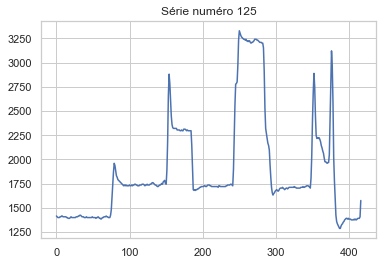

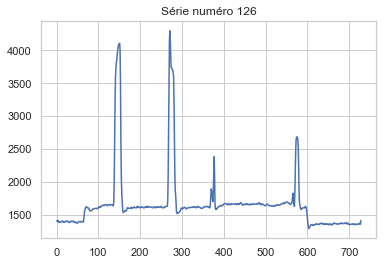

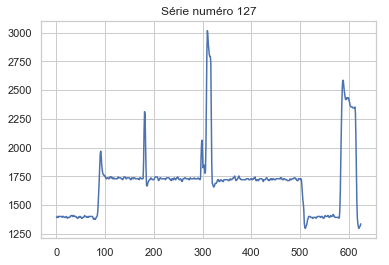

[4, 5, 9, 11, 26, 30, 41, 49, 54, 58, 64, 65, 70, 71, 82, 98, 100, 103, 104, 106, 110, 112, 118]


In [121]:
outlier_prop = 20 / 200  # Ou 20 / (n-20) ?  Ou 20 / 300 ?
OCSVM = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.00000008)
y_pred = OCSVM.fit(data_train).predict(data_test)
print(np.asarray(y_pred)[np.asarray(y_pred) == 1].shape)
anom = []
for i, serie in enumerate(liste_test):
    if y_pred[i] == 1:
        anom.append(i)
        plt.plot(serie)
        plt.title("Série numéro " + str(i) + ", anomalie détectée")
        plt.show()
    else:
        plt.plot(serie)
        plt.title("Série numéro " + str(i))
        plt.show()
print(anom)